# Отборочное задание №1 на стажировку в команду Core ML VK: 
Реализуйте максимально эффективным образом алгоритм иерархической кластеризации с алгоритмом объединения single-link clustering для точек, расположенных на прямой. Опишите алгоритм, а также найдите пример, когда подобный алгоритм показывает «плохие» результаты. ([ссылка на заявку](https://vk.com/jobs?w=job117))

## Решает задачу:
Лисоветин Никита Валерьевич ([github](https://github.com/turing228), [vk](https://vk.com/nikitalisovetin))

# Решение за O(n^2): библиотечное
"Считерим" и используем библиотечный метод ([scipy.cluster.hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)) для точек в сколь угодно мерном пространстве. Нам гарантируют время работы O(n^2), где n - количество точек.

Эта асимптотика легко достигается и без библиотек ([single-link clustering](https://nlp.stanford.edu/IR-book/completelink.html))

In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
X = [[i] for i in [6, 7, 1, 3, 2, 15, 20]]

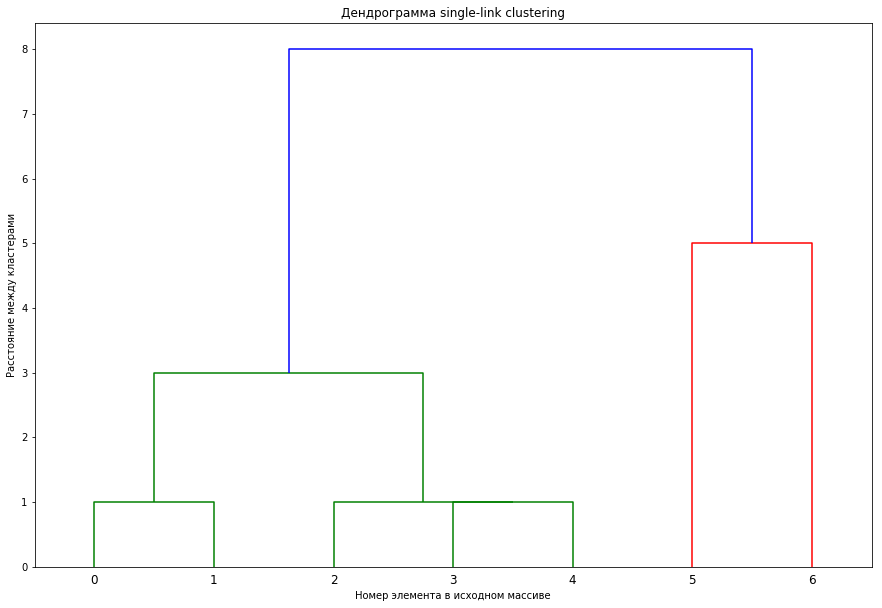

In [2]:
Z = linkage(X, 'single')
fig = plt.figure(figsize=(15, 10))
plt.title('Дендрограмма single-link clustering')
plt.xlabel('Номер элемента в исходном массиве')
plt.ylabel('Расстояние между кластерами')
dn = dendrogram(Z)
plt.show()

# Как интерпретировать дендрограмму?
Номера снизу - номера элементов в массиве X

## Как выглядит массив Z?

[[номер первого элемента, номер второго элемента (если >=n, то номер строчки Z + n-1), расстояние на котором объединили, сколько точек], ...]

In [3]:
Z

array([[ 0.,  1.,  1.,  2.],
       [ 3.,  4.,  1.,  2.],
       [ 2.,  8.,  1.,  3.],
       [ 7.,  9.,  3.,  5.],
       [ 5.,  6.,  5.,  2.],
       [10., 11.,  8.,  7.]])

# Решение за O(nlog(n)): собственное

Воспользуемся тем, что точки на прямой, а не в пространстве - у нас существуют явный порядок на множестве. Это резко уменьшает число ребер - потенциальных кандидатов на минимальное расстояние между кластерами (теперь это одно из O(n) расстояний между соседними кластерами, а не одно из O(n^2) между какими-то двумя)

Кластеры будем хранить как DSU (систему непересекающихся множеств)

## Алгоритм:

1. Инициализируем DSU
2. Сортируем точки за O(nlog(n)) и сохраняем в sortedArray, запоминая исходные номера точек
3. Сохраняем расстояния между соседними точками в отсортированный по расстояниям neighborsDistMap за O(nlogn)
4. Делаем n-1 merge:
    1. Берем очередной минимальный отрезок между соседними вершинками из neighborsDistMap
    2. Если вершинки из одного кластера, переходим к 1. Иначе объединяем кластеры в DSU в вершину с новым номером

## Асимптотика:

Первые 3 шага, как видно, выполняются за O(nlog(n))

Шаг 4.A. всего выполним не более n-1 раз, так как |neighborsDistMap| = n-1

В шаге 4.B. объединение кластеров в моем решении с эвристиками объединения по рангу и сжатия пути происходит за O(alpha(n)) в среднем, где alpha() - обратная функция Аккермана, растущая очень медленно (<=4 для n <= 10^600) ([DSU объединение эвристик](http://www.e-maxx-ru.1gb.ru/algo/dsu#7))

**Итоговая асимптотика:** O(nlog(n))

## Можно ли быстрее?

Нет.

При построении дендрограммы мы, объединяя два кластера, можем за O(1) узнать порядок кластеров на прямой. Давайте узнавать, это не изменит асимптотику. 

Любые две точки изначально в разных кластерах, а в конце - в одном, поэтому был первый момент, когда мы объединили их в один кластер. В этот момент мы узнаем какая левее какой.

Так как точки были любыми, то мы узнали порядок любых точек на прямой. Но любой алгоритм, упорядочивающий n чисел (означающих точки на прямой) сравнениями, в худшем случае выполняет хотя бы Ω(nlog(n) сравнений! ([теорема о нижней оценке для сортировки сравнениями](https://neerc.ifmo.ru/wiki/index.php?title=Теорема_о_нижней_оценке_для_сортировки_сравнениями)).

Поэтому алгоритм, решающий данную задачу, не может работать быстрее, чем за O(nlog(n))

In [4]:
import numpy as np

class DSU:
    def __init__(self, n):
        self.n = n
        self.N = n
        self.parent = np.array([i for i in range(2*n)])
        self.rank = np.zeros(2*n)
        self.volume = np.concatenate([np.ones(n), np.zeros(n)])

    def findSet(self, v):
        v = int(v)
        if (v == self.parent[v]):
            return v
        self.parent[v] = self.findSet(self.parent[v])
        return self.parent[v]

    def unionSets(self, a, b):
        a = self.findSet(a)
        b = self.findSet(b)
        if (a != b):
            if (self.rank[a] < self.rank[b]):
                a, b = b, a
            self.volume[self.N] = self.volume[self.parent[a]] + self.volume[self.parent[b]]
            self.parent[b] = self.N
            self.parent[a] = self.N
            self.N += 1
            if (self.rank[a] == self.rank[b]):
                self.rank[a] += 1
            return (self.volume[self.N - 1])

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

class SingleLink:    
    def __init__(self, array):
        self.n = len(array)
        
        def getSorted():
            preSortedArray = []
            for i in enumerate(array):
                preSortedArray.append(i)
            def takeSecond(element):
                return element[1]
            return np.array(sorted(preSortedArray,key=takeSecond))
        
        self.sortedArray = getSorted()
        
        
        def getNeighborsDistMap():
            neighborsDistMap = []
            for i in range(self.n - 1):
                x = self.sortedArray[i]
                y = self.sortedArray[i + 1]
                neighborsDistMap.append((y[1] - x[1], [x[0], y[0]]))

            return sorted(neighborsDistMap)
        
        self.neighborsDistMap = getNeighborsDistMap()
        
        def link():
            dsu = DSU(self.n)
            Z = []
            self.numClusters = self.n
            for trio in self.neighborsDistMap:
                d = trio[0]
                x = dsu.findSet(trio[1][0])
                y = dsu.findSet(trio[1][1])
                z = dsu.unionSets(x, y)
                if (x != y):
                    Z.append([x, y, d, z])
                    
            return np.array(Z)
        
        self.Z = link()
        
    def draw(self, numClusters = 1):
        
        if (numClusters > self.n):
            numClusters = self.n
            print(f'Указано слишком большое число кластеров. Число кластеров понижено до n={self.n}')
            
        if (numClusters < 1):
            numClusters = 1
            print(f'Указано слишком маленькое число кластеров. Число кластеров увеличено до n={1}')
            
        fig = plt.figure(figsize=(15, 10))
        
        distance = self.Z[self.n - 2][2] + 1
        minDistance = self.Z[self.n - 2][2]
        maxDistance = '+infinity'
        if (numClusters != 1):
            if (numClusters == self.n):
                minDistance = 0
                maxDistance = self.Z[self.n - numClusters][2]
                distance = self.Z[self.n - numClusters][2] / 2
            else:
                minDistance = self.Z[self.n - numClusters - 1][2]
                maxDistance = self.Z[self.n - numClusters][2]
                distance = (self.Z[self.n - numClusters][2] + self.Z[self.n - numClusters - 1][2]) / 2
            plt.axhline(distance)
        
        plt.title(f'Дендрограмма single-link clustering. Число кластеров {numClusters}. Высота линии {distance} (от {minDistance} до {maxDistance})')
        plt.xlabel('Номер элемента в исходном массиве')
        plt.ylabel('Расстояние между кластерами')
            
        dn = dendrogram(self.Z)
        plt.show()

In [6]:
slink = SingleLink([6, 7, 1, 3, 2, 15, 20])

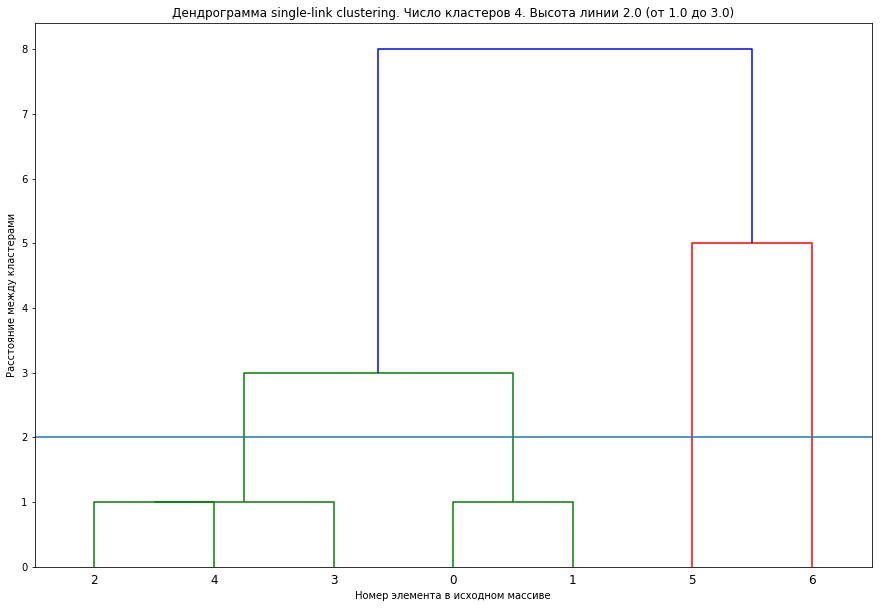

In [7]:
slink.draw(4)

# Проверка времени работы
Покажем, что асимптотика времени выполнения O(nlogn), а не O(n^2)

In [8]:
import time

ax = []
ay = []
x = 0
for i in range(20):
    x += 10000
    start = time.time()
    slink = SingleLink(np.random.rand(x))
    end = time.time()
    ax.append(x)
    ay.append(end - start)
    print(x, end - start)

10000 0.10235118865966797
20000 0.22584962844848633
30000 0.3277006149291992
40000 0.5110785961151123
50000 0.7189509868621826
60000 0.7677817344665527
70000 0.9379622936248779
80000 1.2007367610931396
90000 1.3015873432159424
100000 1.4767975807189941
110000 1.6981110572814941
120000 1.611607551574707
130000 2.0581302642822266
140000 2.1339452266693115
150000 2.1535685062408447
160000 2.469348907470703
170000 3.0138049125671387
180000 2.6389808654785156
190000 3.1216158866882324
200000 3.1573586463928223


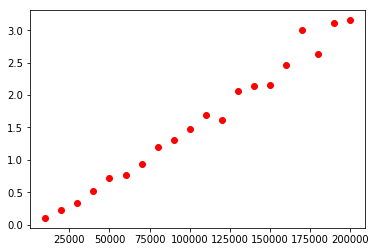

In [9]:
import matplotlib.pyplot as plt

plt.plot(ax, ay, 'ro')
#plt.axis([0, 6, 0, 20])
plt.show()

## Вывод:

Это явно не O(n^2) и очень похоже на O(n), что недалеко от O(nlogn)

# Когда такой алгоритм показывает "плохие" результаты?

"Плохие" в смысле времени работы:
1. Когда наш массив worst case для нашего алгоритма сортировки и мы могли бы сразу выдать single-link clustering. Стоит заметить, что в Python sort алгоритм - Timsort ([python sort time complexity](https://stackoverflow.com/questions/14434490/what-is-the-complexity-of-this-python-sort-method)), который adaptive sorting algoritm, то есть, например, работающий за линию в случае получения упорядоченного массива

"Плохие" в смысле качества кластеризации:
1. Single link clustering сравнивает расстояния между кластерами, забывая про размер и "длину" кластеров (то есть крайние точки кластера могут уже быть сильно дальше друг от друга, чем расстояния между кластерами, но кластер продолжит расширяться). Это, безусловно, противоречит с идеей кластеризации - поиска точек сгущений (областей с глобально высокой плотностью точек вокруг одного центра)
2. В самом алгоритме заложено, что рассматриваются пары кластеров и расстояния между ними, а не все кластеры сразу. То есть при объединении кластеров мы крайне слабо используем информацию о других кластерах и о природе самих кластеров (как распределяются плотности точек в них). Это ведет к тому, что мы можем задать такие параметры, чтобы различить любые два крупных кластера, но не можем задать такие, чтобы различить все сразу. Это хорошо видно в примере №3

## Рассмотрим несколько примеров

## Пример №1. Хороший

In [10]:
d = np.random.RandomState(312302).normal(size=150)/3

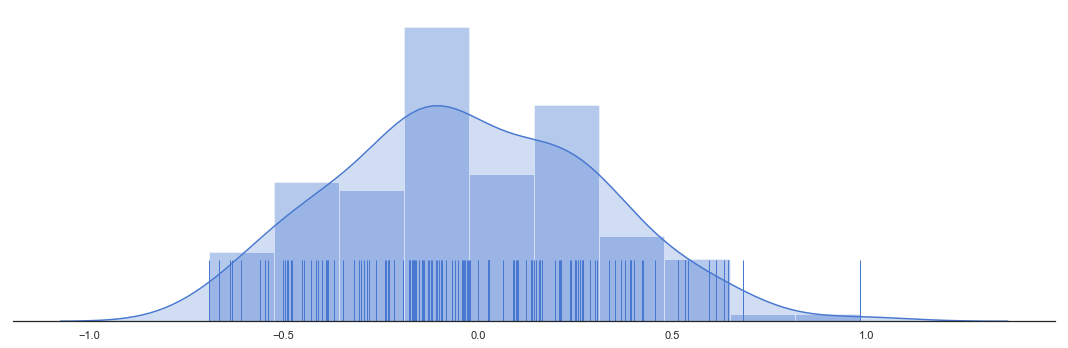

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(15, 5), sharex=True)
sns.despine(left=True)

sns.distplot(d, color="b", kde_kws={"shade": True})
sns.rugplot(d, height=0.2, axis='x')
plt.setp(axes, yticks=[])
plt.tight_layout()

## Пояснение примера:

Это нормальное распределение от -1 до +1. В 0 точек больше всего, к краям - меньше. Ожидаемый кластер в 0. Если присмотреться (на столбцы частотности), то есть еще кластеры с центрами в -0.5 и в 0.3

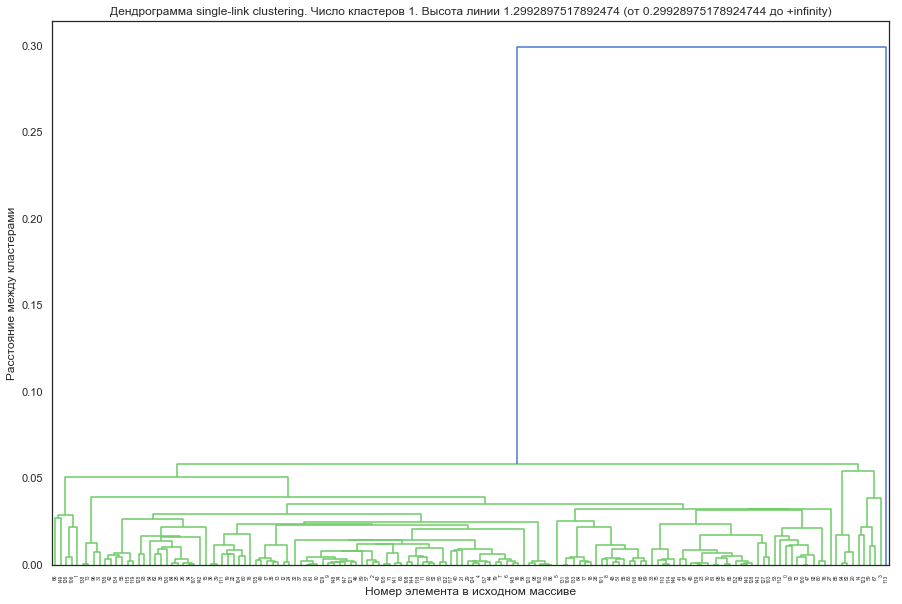

In [12]:
SingleLink(d).draw()

## Вывод:
И как выбрать число кластеров? Поможет ли нам такая кластеризация? Возможно, более жесткие критерии дали бы лучшие результаты (близость точек), но в single-link clustering их нет. Мы не видим никакой разницы между скоплениями точек.

Если мы видим график сверху, то, естественно, следует пытаться кластеризовать четче (правда, иногда это невозможно). Поэтому проверку программа можно считать, что прошла.

## Пример №2
Теперь объединим несколько нормальных распределений

In [13]:
d = np.concatenate((np.random.RandomState(10).normal(size=500)/3, np.random.RandomState(10).normal(size=500)/3+1.4))

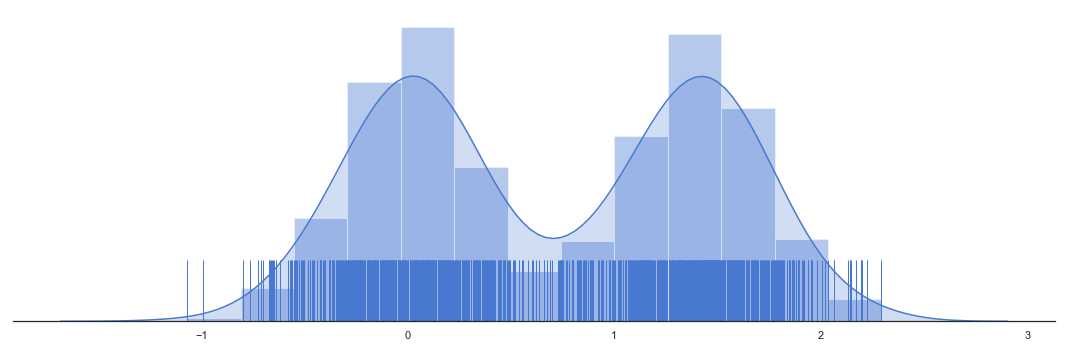

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(15, 5), sharex=True)
sns.despine(left=True)

sns.distplot(d, color="b", kde_kws={"shade": True})
sns.rugplot(d, height=0.2, axis='x')
plt.setp(axes, yticks=[])
plt.tight_layout()

## Пояснение примера:
Два больших кластера с центрами в 0 и 1.5 и, возможно, несколько маленьких (они видны в середине и по краям)

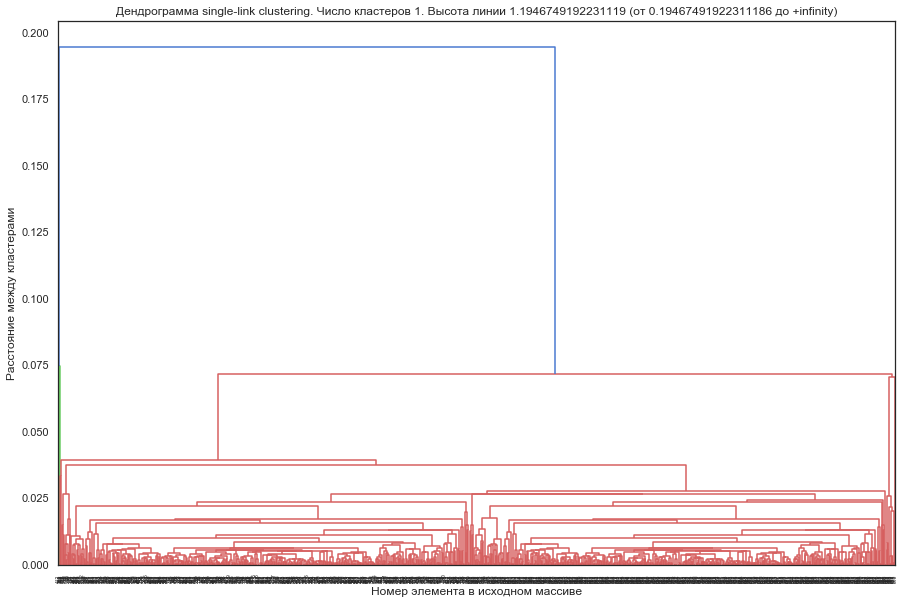

In [15]:
SingleLink(d).draw()

## Вывод:

Нет таких параметров "высоты" (расстояния между кластерами) и количества кластеров, чтобы получить два очевидных кластера. Или их очень сложно подобрать, алгоритм работает плохо!

# Пример 3:

In [16]:
d = np.concatenate((np.random.RandomState(10).normal(size=1000)/3, np.random.RandomState(100).normal(size=1000)/3+2,
                   np.random.RandomState(200).normal(size=1000)/3+3.8))

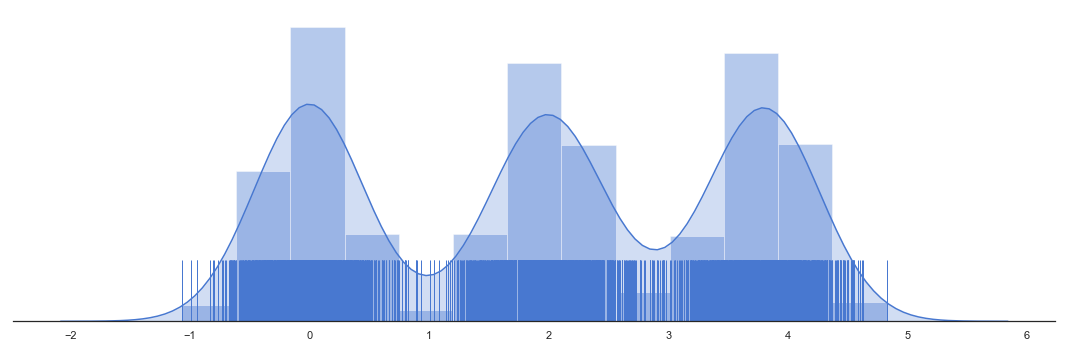

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(figsize=(15, 5), sharex=True)
sns.despine(left=True)

sns.distplot(d, color="b", kde_kws={"shade": True})
sns.rugplot(d, height=0.2, axis='x')
plt.setp(axes, yticks=[])
plt.tight_layout()

## Пояснение примера:
Три больших кластера с центрами в 0, 2 и 3.8

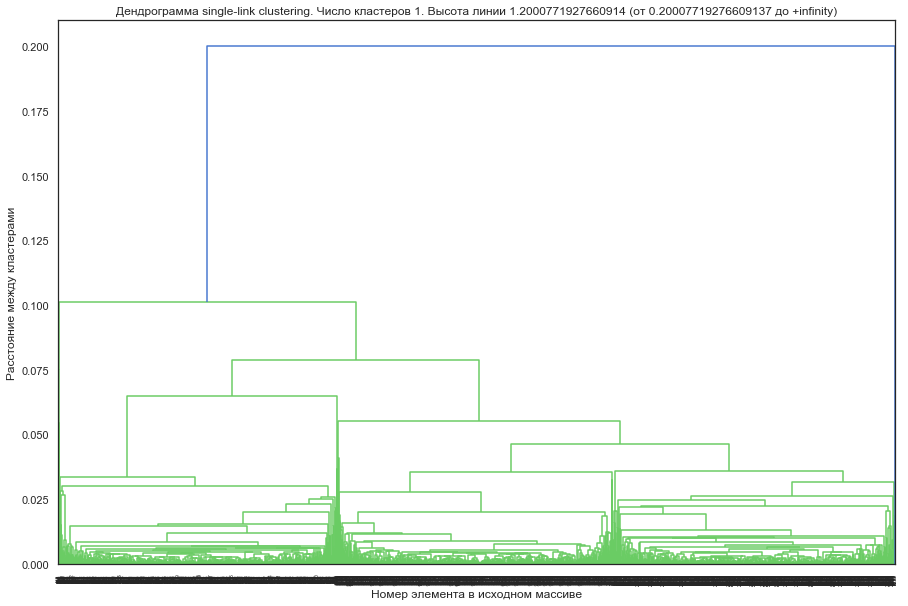

In [18]:
SingleLink(d).draw()

# Вывод:

Хоть мы и можем по косвенным признакам понять, что есть три кластера (сгущения вертикальных линий), это нам не помогает сильнее, чем график seaborn. Нет таких параметров (расстояние между кластерами или их количество), по которым можно было предъявить в SingleLink'е нужные кластеры

Мы можем отделить 1-ый кластер от 2-го, 2-ой от 3-его, но все друг от друга - нет. Это подтверждает глобальную проблему single-link clustering алгоритма, не рассматривающего точки сгущения по отдельности, а сфокусированного на объединение ближайших соседей!